<a href="https://colab.research.google.com/github/PetrusAriaa/python-projects/blob/main/Adhyasta_Stall_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/terbang_auto2.csv')
data.head(4)

,time,mode,aspd,gspd,lat,lon,r,p,y,alt,...,bearing,rad,latacc,climb,srv0,srv1,srv2,srv3,lmt0,lmt1
0,1679126905688,MANU,0.79,1.00,-7.766487,110.233482,33.78,-29.74,272.43,-3.33,...,140.87,0.66,-0.68,-0.68,1500,1500,1497,1000,0.0,1.0
1,1679126905837,MANU,0.81,1.02,-7.766487,110.233482,34.46,-31.09,273.71,-3.32,...,140.87,0.66,-0.68,-0.68,1500,1500,1498,1000,0.0,1.0
2,1679126905908,MANU,0.85,1.09,-7.766487,110.233482,35.27,-30.32,273.63,-3.32,...,140.87,0.66,-0.74,-0.74,1500,1500,1497,1000,0.0,1.0
3,1679126905989,MANU,0.88,1.10,-7.766487,110.233482,34.65,-29.17,274.59,-3.32,...,140.87,0.66,-0.74,-0.74,1500,1500,1497,1000,0.0,1.0


In [ ]:
corr = data.corr()
corr.aspd

<ipython-input-37-a6cf353dc86c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


time        0.557968
aspd        1.000000
gspd        0.965443
lat        -0.018039
lon         0.015190
r          -0.229584
p           0.584817
y          -0.370021
alt         0.857170
navr        0.009099
navp        0.106491
navy       -0.002675
navalt      0.323813
navspeed    0.377698
hdop       -0.090036
sat        -0.026498
turn        0.515275
bearing     0.294145
rad         0.353065
latacc     -0.085420
climb      -0.085420
srv0        0.179867
srv1       -0.081650
srv2        0.175828
srv3        0.802367
lmt0             NaN
lmt1        0.872384
Name: aspd, dtype: float64

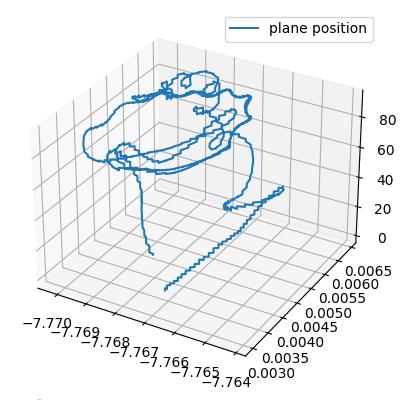

In [ ]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(data.lat[2000:], data.lon[2000:], data.alt[2000:], label='plane position')
ax.legend()

plt.show()

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

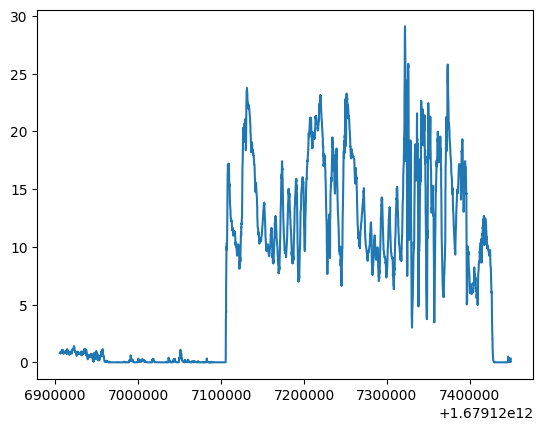

In [ ]:
plt.plot(data.time, data.aspd)

### Framing the data

In [ ]:
from copy import deepcopy as dc

df = data[['time', 'aspd']]

def prepare_dataframe_for_lstm(df, n_steps):
  df = dc(df)

  df.set_index('time', inplace=True)

  for i in range(1, n_steps+1):
    df[f'aspd(t-{i})'] = df['aspd'].shift(i)

  df.dropna(inplace=True)
  return df

frames = 8
shifted_df = prepare_dataframe_for_lstm(df, frames)
shifted_df.head(4)

,aspd,aspd(t-1),aspd(t-2),aspd(t-3),aspd(t-4),aspd(t-5),aspd(t-6),aspd(t-7),aspd(t-8)
time,,,,,,,,,
1679126906453,0.85,0.86,0.86,0.88,0.88,0.88,0.85,0.81,0.79
1679126906554,0.85,0.85,0.86,0.86,0.88,0.88,0.88,0.85,0.81
1679126906607,0.84,0.85,0.85,0.86,0.86,0.88,0.88,0.88,0.85
1679126906804,0.85,0.84,0.85,0.85,0.86,0.86,0.88,0.88,0.88


In [ ]:
shifted_df_np = shifted_df.to_numpy()
shifted_df_np

array([[0.85, 0.86, 0.86, ..., 0.85, 0.81, 0.79],
       [0.85, 0.85, 0.86, ..., 0.88, 0.85, 0.81],
       [0.84, 0.85, 0.85, ..., 0.88, 0.88, 0.85],
       ...,
       [0.13, 0.04, 0.05, ..., 0.05, 0.06, 0.08],
       [0.23, 0.13, 0.04, ..., 0.04, 0.05, 0.06],
       [0.32, 0.23, 0.13, ..., 0.03, 0.04, 0.05]])

### Data Preprocess with minmaxscaler

In [ ]:
X = shifted_df_np[:, 1:]
y = shifted_df_np[:, 0]

X = dc(np.flip(X, axis=1))
X

array([[0.79, 0.81, 0.85, ..., 0.88, 0.86, 0.86],
       [0.81, 0.85, 0.88, ..., 0.86, 0.86, 0.85],
       [0.85, 0.88, 0.88, ..., 0.86, 0.85, 0.85],
       ...,
       [0.08, 0.06, 0.05, ..., 0.03, 0.05, 0.04],
       [0.06, 0.05, 0.04, ..., 0.05, 0.04, 0.13],
       [0.05, 0.04, 0.03, ..., 0.04, 0.13, 0.23]])

In [ ]:
split_index = int(len(X) * .85)

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4557, 8), (805, 8), (4557,), (805,))

In [ ]:
X_train = X_train.reshape((-1, frames, 1))
X_test = X_test.reshape((-1, frames, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1,1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4557, 8, 1), (805, 8, 1), (4557, 1), (805, 1))

In [ ]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([4557, 8, 1]),
 torch.Size([805, 8, 1]),
 torch.Size([4557, 1]),
 torch.Size([805, 1]))

In [ ]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y
  
  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([32, 8, 1]) torch.Size([32, 1])


In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size,
                        num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

model = LSTM(1, 16, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [ ]:
def train_one_epoch():
  model.train(True)
  print(f'Epoch: {epoch + 1}')
  running_loss = .0

  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_fn(output, y_batch)
    running_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index % 100 == 99:
      avg_loss_across_batches = running_loss/100
      print(f'Batch {batch_index+1}, Loss: {avg_loss_across_batches:.3f}')

      running_loss = .0
  print()

In [ ]:
def validate_one_epoch():
  model.train(False)
  running_loss = .0

  for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch)
      loss = loss_fn(output, y_batch)
      running_loss += loss
  
  avg_loss_across_batches = running_loss/100

  print(f'Val Loss: {avg_loss_across_batches:.3f}')
  print('****************************************')
  print()

In [ ]:
learning_rate = .001
num_epochs = 200
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  train_one_epoch()
  validate_one_epoch()

Epoch: 1
Batch 100, Loss: 113.992

Val Loss: 20.457
****************************************

Epoch: 2
Batch 100, Loss: 68.843

Val Loss: 9.762
****************************************

Epoch: 3
Batch 100, Loss: 37.449

Val Loss: 5.964
****************************************

Epoch: 4
Batch 100, Loss: 24.726

Val Loss: 3.897
****************************************

Epoch: 5
Batch 100, Loss: 16.689

Val Loss: 2.625
****************************************

Epoch: 6
Batch 100, Loss: 11.719

Val Loss: 1.804
****************************************

Epoch: 7
Batch 100, Loss: 7.938

Val Loss: 1.260
****************************************

Epoch: 8
Batch 100, Loss: 6.033

Val Loss: 0.889
****************************************

Epoch: 9
Batch 100, Loss: 4.484

Val Loss: 0.640
****************************************

Epoch: 10
Batch 100, Loss: 3.162

Val Loss: 0.479
****************************************

Epoch: 11
Batch 100, Loss: 2.428

Val Loss: 0.365
*******************************

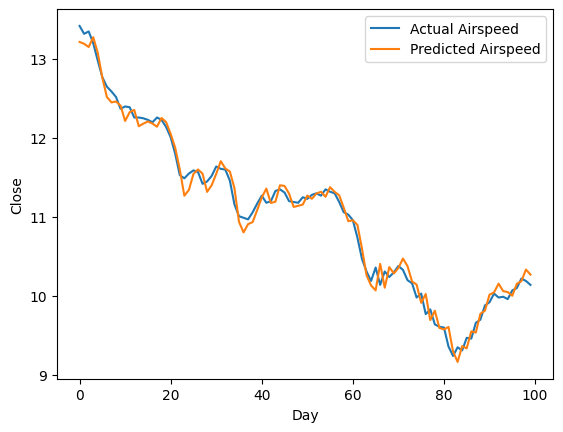

In [ ]:
with torch.no_grad():
  predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train[2000:2100], label='Actual Airspeed')
plt.plot(predicted[2000:2100], label='Predicted Airspeed')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
X = data[['alt', 'r', 'p', 'y']]
y = data.aspd

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.85)
rf = RandomForestRegressor(n_estimators=250)
rf.fit(X, y)
y_pred = rf.predict(X)
print(mean_squared_error(y, y_pred), r2_score(y, y_pred))


0.07111018196975832 0.9987201908170019


In [ ]:
t = []
for i in range(2000, 2100):
  t.append(i)

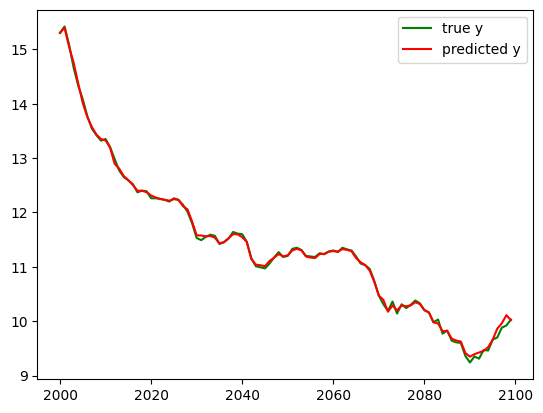

In [ ]:
img2, ax = plt.subplots()
ax.plot(t, y[2000:2100], c='green', label='true y')
ax.plot(t, y_pred[2000:2100], c='red', label='predicted y')
plt.legend()
plt.show()

In [ ]:
no_aspd = pd.read_csv('/content/drive/MyDrive/Datasets/terbang2.csv')
no_aspd.head(4)

,time,mode,aspd,gspd,lat,lon,r,p,y,alt,...,bearing,rad,latacc,climb,srv0,srv1,srv2,srv3,lmt0,lmt1
0,1681695638876,AAAA,0.0,0.0,0.0,0.0,-0.12,6.93,-104.46,-1.01,...,0.0,0.0,0.0,0.0,1500,1500,1499,1000,0.0,0.0
1,1681695638876,AAAA,0.0,0.0,0.0,0.0,-0.07,7.25,-104.77,-1.09,...,0.0,0.0,0.0,0.0,1500,1500,1499,1000,0.0,0.0
2,1681695638876,AAAA,0.0,0.0,0.0,0.0,0.15,7.60,-105.07,-0.84,...,0.0,0.0,0.0,0.0,1500,1500,1499,1000,0.0,0.0
3,1681695639009,AAAA,0.0,0.0,0.0,0.0,2.76,10.21,-104.60,-1.26,...,0.0,0.0,0.0,0.0,1500,1500,1499,1000,0.0,0.0


In [ ]:
d = no_aspd[['alt', 'r', 'p', 'y']]

asp = rf.predict(d)

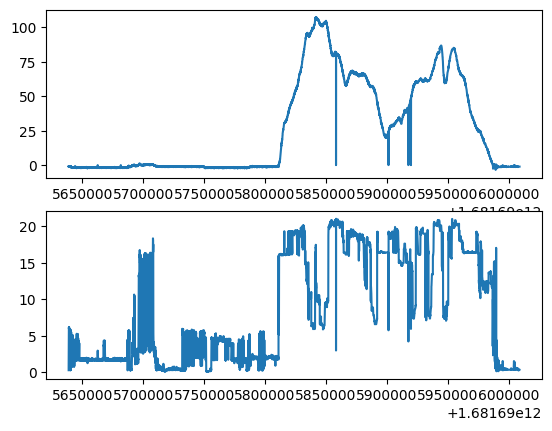

In [ ]:
fig3 , axd = plt.subplots(2, 1)
axd[0].plot(no_aspd.time, no_aspd.alt)
axd[1].plot(no_aspd.time, asp)

plt.show()